## Description:
建立Wide&Deep Model在cretio数据集上进行点击率预测的任务

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# from torchkeras import summary, Model

from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

## 数据准备

In [4]:
file_path = './preprocessed_data/'

In [5]:
def prepared_data(file_path):
    
    # 读入训练集，验证集和测试集
    train = pd.read_csv(file_path + 'train_set.csv')
    val = pd.read_csv(file_path + 'val_set.csv')
    test = pd.read_csv(file_path + 'test_set.csv')
    
    trn_x, trn_y = train.drop(columns='Label').values, train['Label'].values
    val_x, val_y = val.drop(columns='Label').values, val['Label'].values
    test_x = test.values
    
    fea_col = np.load(file_path + 'fea_col.npy', allow_pickle=True)
    
    return fea_col, (trn_x, trn_y), (val_x, val_y), test_x

In [6]:
fea_cols, (trn_x, trn_y), (val_x, val_y), test_x = prepared_data(file_path)

In [7]:
# 把数据构建成数据管道
dl_train_dataset = TensorDataset(torch.tensor(trn_x).float(), torch.tensor(trn_y).float())
dl_val_dataset = TensorDataset(torch.tensor(val_x).float(), torch.tensor(val_y).float())

dl_train = DataLoader(dl_train_dataset, shuffle=True, batch_size=32)
dl_val = DataLoader(dl_val_dataset, shuffle=True, batch_size=32)

In [8]:
# 看一下数据
for b in iter(dl_train):
    print(b[0].shape, b[1])
    break

torch.Size([32, 39]) tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.])


## 构建模型
这里依然是使用继承nn.Module基类构建模型， 并辅助应用模型容器进行封装， Wide&Deep的模型结构如下：

![](img/w&d.png)

这个模型搭建起来，相对比较简单， 主要分为wide部分， Deep部分和两者的拼接

In [9]:
class Linear(nn.Module):
    """
    Linear part
    """
    def __init__(self, input_dim):
        super(Linear, self).__init__()
        self.linear = nn.Linear(in_features=input_dim, out_features=1)
    
    def forward(self, x):
        return self.linear(x)

class Dnn(nn.Module):
    """
    Dnn part
    """
    def __init__(self, hidden_units, dropout=0.):
        """
        hidden_units: 列表， 每个元素表示每一层的神经单元个数， 比如[256, 128, 64], 两层网络， 第一层神经单元128， 第二层64， 第一个维度是输入维度
        dropout: 失活率
        """
        super(Dnn, self).__init__()
        
        self.dnn_network = nn.ModuleList([nn.Linear(layer[0], layer[1]) for layer in list(zip(hidden_units[:-1], hidden_units[1:]))])
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x):
        
        for linear in self.dnn_network:
            x = linear(x)
            x = F.relu(x)
        
        x = self.dropout(x)
        return x

In [10]:
class WideDeep(nn.Module):
    def __init__(self, feature_columns, hidden_units, dnn_dropout=0.):
        super(WideDeep, self).__init__()
        self.dense_feature_cols, self.sparse_feature_cols = feature_columns
        
        # embedding 
        self.embed_layers = nn.ModuleDict({
            'embed_' + str(i): nn.Embedding(num_embeddings=feat['feat_num'], embedding_dim=feat['embed_dim'])
            for i, feat in enumerate(self.sparse_feature_cols)
        })
        
        hidden_units.insert(0, len(self.dense_feature_cols) + len(self.sparse_feature_cols)*self.sparse_feature_cols[0]['embed_dim'])
        self.dnn_network = Dnn(hidden_units)
        self.linear = nn.Linear(len(self.dense_feature_cols),1)
        self.final_linear = nn.Linear(hidden_units[-1], 1)
    
    def forward(self, x):
        dense_input, sparse_inputs = x[:, :len(self.dense_feature_cols)], x[:, len(self.dense_feature_cols):]
        sparse_inputs = sparse_inputs.long()
        sparse_embeds = [self.embed_layers['embed_'+str(i)](sparse_inputs[:, i]) for i in range(sparse_inputs.shape[1])]
        sparse_embeds = torch.cat(sparse_embeds, axis=-1)
        
        dnn_input = torch.cat([sparse_embeds, dense_input], axis=-1)
        
        # Wide
        wide_out = self.linear(dense_input)
        
        # Deep
        deep_out = self.dnn_network(dnn_input)
        deep_out = self.final_linear(deep_out)
        
        # out
        outputs = F.sigmoid(0.5 * (wide_out + deep_out))
        
        return outputs  

In [11]:
# 建立模型
hidden_units = [256, 128, 64]
dnn_dropout = 0.

model = WideDeep(fea_cols, hidden_units, dnn_dropout)
#summary(model, input_shape=(trn_x.shape[1],))

In [12]:
# 测试一下模型
for fea, label in iter(dl_train):
    out = model(fea)
    print(out)
    break

tensor([[0.4825],
        [0.4891],
        [0.4853],
        [0.4576],
        [0.4878],
        [0.4863],
        [0.4840],
        [0.4823],
        [0.4885],
        [0.4849],
        [0.4583],
        [0.4861],
        [0.4764],
        [0.4849],
        [0.4824],
        [0.4788],
        [0.4863],
        [0.4701],
        [0.4834],
        [0.4838],
        [0.4846],
        [0.4839],
        [0.4820],
        [0.4773],
        [0.4862],
        [0.4845],
        [0.4785],
        [0.4855],
        [0.4746],
        [0.4849],
        [0.4684],
        [0.4846]], grad_fn=<SigmoidBackward>)


## 模型的训练

In [13]:
# 模型的相关设置
def auc(y_pred, y_true):
    pred = y_pred.data
    y = y_true.data
    return roc_auc_score(y, pred)

loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
metric_func = auc
metric_name = 'auc'

In [14]:
# 脚本训练风格
epochs = 10
log_step_freq = 10

dfhistory = pd.DataFrame(columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name])

print('start_training.........')
nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('========'*8 + '%s' %nowtime)

for epoch in range(1, epochs+1):
    
    # 训练阶段
    model.train()
    loss_sum = 0.0
    metric_sum = 0.0
    step = 1
    
    for step, (features, labels) in enumerate(dl_train, 1):
        # 梯度清零
        optimizer.zero_grad()
        
        # 正向传播
        predictions = model(features)
        predictions = predictions.squeeze(-1)  #使得输出与标签的size一致 否则会报错
        loss = loss_func(predictions, labels)
        try:
            metric = metric_func(predictions, labels)
        except ValueError:
            pass
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        # 打印batch级别日志
        loss_sum += loss.item()
        metric_sum += metric.item()
        if step % log_step_freq == 0:
            print(("[step=%d] loss: %.3f, " + metric_name + ": %.3f") % (step, loss_sum/step, metric_sum/step));
    
    # 验证阶段
    model.eval()
    val_loss_sum = 0.0
    val_metric_sum = 0.0
    val_step = 1
    
    for val_step, (features, labels) in enumerate(dl_val, 1):
        with torch.no_grad():
            predictions = model(features)
            predictions = predictions.squeeze(-1)  #使得输出与标签的size一致 否则会报错
            val_loss = loss_func(predictions, labels)
            try:
                val_metric = metric_func(predictions, labels)
            except ValueError:
                pass
        
        val_loss_sum += val_loss.item()
        val_metric_sum += val_metric.item()
    
    # 记录日志
    info = (epoch, loss_sum/step, metric_sum/step, val_loss_sum/val_step, val_metric_sum/val_step)
    dfhistory.loc[epoch-1] = info
    
    # 打印日志
    print(("\nEPOCH=%d, loss=%.3f, " + metric_name + " = %.3f, val_loss=%.3f, " + "val_" + metric_name + " = %.3f") %info)
    nowtime = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print('\n' + '=========='* 8 + '%s' %nowtime)
    
print('Finished Training')

start_training.........
================================================================2022-10-17 20:43:50
[step=10] loss: 0.626, auc: 0.446
[step=20] loss: 0.583, auc: 0.474
[step=30] loss: 0.547, auc: 0.501
[step=40] loss: 0.544, auc: 0.512

EPOCH=1, loss=0.544, auc = 0.512, val_loss=0.457, val_auc = 0.627

================================================================================2022-10-17 20:43:51
[step=10] loss: 0.547, auc: 0.678
[step=20] loss: 0.520, auc: 0.748
[step=30] loss: 0.495, auc: 0.733
[step=40] loss: 0.486, auc: 0.725

EPOCH=2, loss=0.486, auc = 0.725, val_loss=0.430, val_auc = 0.672

================================================================================2022-10-17 20:43:51
[step=10] loss: 0.477, auc: 0.813
[step=20] loss: 0.435, auc: 0.827
[step=30] loss: 0.434, auc: 0.832
[step=40] loss: 0.435, auc: 0.820

EPOCH=3, loss=0.435, auc = 0.820, val_loss=0.434, val_auc = 0.664

================================================================================

In [15]:
dfhistory

,epoch,loss,auc,val_loss,val_auc
0,1.0,0.544223,0.511614,0.457104,0.626770
1,2.0,0.485533,0.724905,0.429970,0.671800
2,3.0,0.435407,0.819750,0.434282,0.663592
3,4.0,0.341225,0.914143,0.508214,0.634606
4,5.0,0.214148,0.970616,0.725189,0.585270
5,6.0,0.108509,0.994901,0.865610,0.670690
6,7.0,0.046308,0.999178,0.963788,0.661687
7,8.0,0.014735,1.000000,1.164902,0.633054
8,9.0,0.009361,0.999886,1.197910,0.662281
9,10.0,0.003578,1.000000,1.311444,0.658093


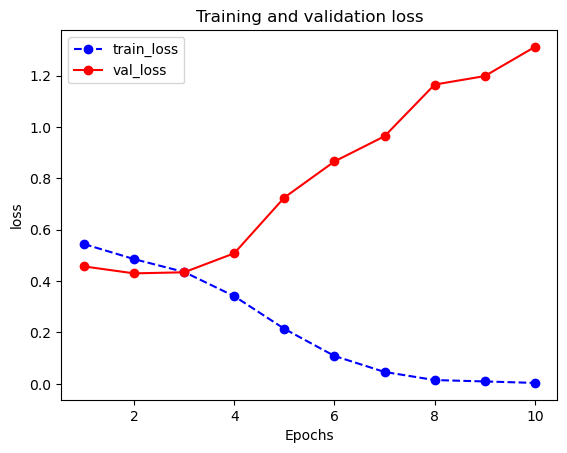

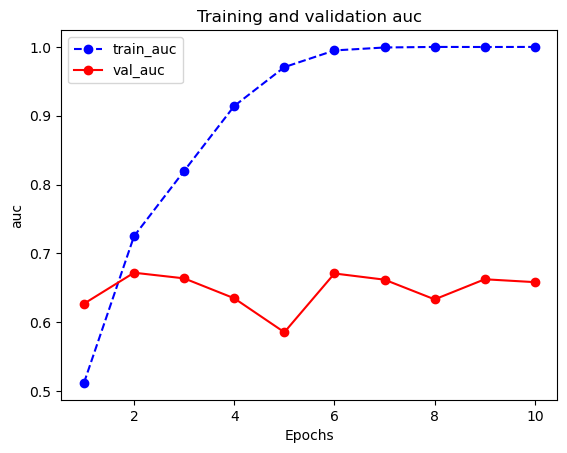

In [16]:
def plot_metric(dfhistory, metric):
    train_metrics = dfhistory[metric]
    val_metrics = dfhistory['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()


# 观察损失和准确率的变化
plot_metric(dfhistory,"loss")
plot_metric(dfhistory,"auc")

出现过拟合了，其实，并且比较严重

In [17]:
# 预测
y_pred_probs = model(torch.tensor(test_x).float())
y_pred = torch.where(y_pred_probs>0.5, torch.ones_like(y_pred_probs), torch.zeros_like(y_pred_probs))

In [18]:
y_pred.data


tensor([[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
      